In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
cambios_compradores_2020_2023 = pd.read_csv('data/out/cambios_compradores_2020_2023.csv')

In [16]:
oportunidad_compradores_2023 = pd.read_csv('data/out/oportunidad_compradores_2023.csv')

In [17]:
cambios_vs_oportunidad=pd.merge(cambios_compradores_2020_2023, oportunidad_compradores_2023, on=['GRUPO_EDAD','ZONA','ESTRATO'], how='inner')

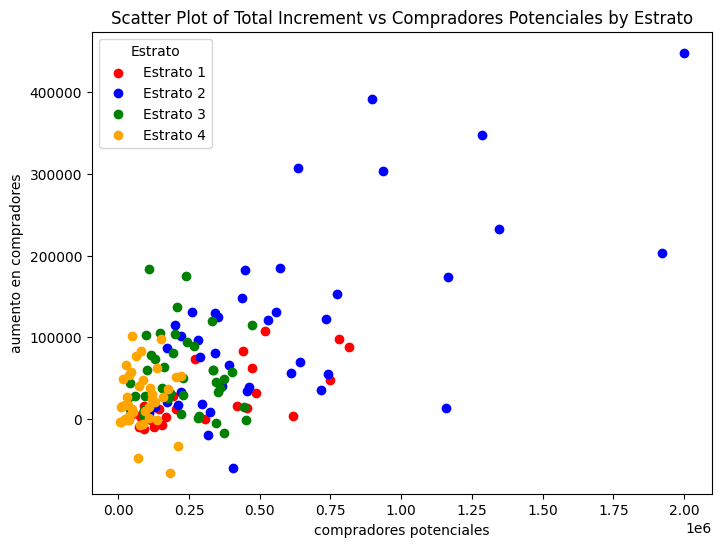

In [18]:
# Updating the colors dictionary for the new category
colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange'}
cambios_vs_oportunidad['color'] = cambios_vs_oportunidad['ESTRATO'].map(colors)


# Plotting the scatter plot with the updated categories
plt.figure(figsize=(8, 6))
for estrato, color in colors.items():
    subset = cambios_vs_oportunidad[cambios_vs_oportunidad['ESTRATO'] == estrato]
    plt.scatter(subset['FAC_PER_P7_19_2'], subset['total_increment'], label=f'Estrato {estrato}', color=color)

plt.xlabel('compradores potenciales')
plt.ylabel('aumento en compradores')
plt.title('Scatter Plot of Total Increment vs Compradores Potenciales by Estrato')
plt.legend(title='Estrato')
plt.show()

In [19]:
cambios_vs_oportunidad['ZONA'].unique()

array(['centro_sur_y_oriente', 'ciudad_de_mexico', 'noreste', 'noroeste',
       'occidente_y_bajio', 'sur'], dtype=object)

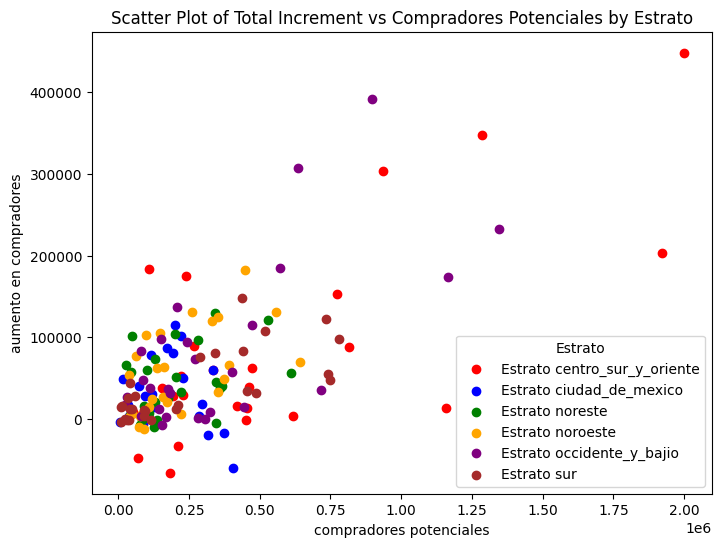

In [20]:
# Updating the colors dictionary for the new category
colors = {'centro_sur_y_oriente': 'red', 'ciudad_de_mexico': 'blue', 'noreste': 'green', 'noroeste': 'orange', 'occidente_y_bajio': 'purple', 'sur': 'brown'}
cambios_vs_oportunidad['color'] = cambios_vs_oportunidad['ZONA'].map(colors)


# Plotting the scatter plot with the updated categories
plt.figure(figsize=(8, 6))
for zona, color in colors.items():
    subset = cambios_vs_oportunidad[cambios_vs_oportunidad['ZONA'] == zona]
    plt.scatter(subset['FAC_PER_P7_19_2'], subset['total_increment'], label=f'Estrato {zona}', color=color)

plt.xlabel('compradores potenciales')
plt.ylabel('aumento en compradores')
plt.title('Scatter Plot of Total Increment vs Compradores Potenciales by Estrato')
plt.legend(title='Estrato')
plt.show()

In [21]:
cambios_vs_oportunidad_clustering = cambios_vs_oportunidad[['GRUPO_EDAD','ZONA','ESTRATO','FAC_PER_P7_19_2','total_increment']].copy()

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Defining the categorical and numerical columns
categorical_cols = ['GRUPO_EDAD', 'ZONA', 'ESTRATO']
numerical_cols = ['FAC_PER_P7_19_2', 'total_increment']

# One-hot encoding the categorical variables
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(cambios_vs_oportunidad_clustering[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols), index=cambios_vs_oportunidad_clustering.index)

# Scaling the numerical columns
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(cambios_vs_oportunidad_clustering[numerical_cols])
scaled_num_df = pd.DataFrame(scaled_nums, columns=numerical_cols, index=cambios_vs_oportunidad_clustering.index)

# Combining the encoded categorical and scaled numerical data
processed_df = pd.concat([encoded_cat_df, scaled_num_df], axis=1)

# Applying KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
cambios_vs_oportunidad_clustering['cluster'] = kmeans.fit_predict(processed_df)

# Display the dataframe to verify results
cambios_vs_oportunidad_clustering.head()

,GRUPO_EDAD,ZONA,ESTRATO,FAC_PER_P7_19_2,total_increment,cluster
0,a,centro_sur_y_oriente,1,618846.0,3247.0,1
1,a,centro_sur_y_oriente,2,1284562.0,347107.0,0
2,a,centro_sur_y_oriente,3,240886.0,174732.0,1
3,a,centro_sur_y_oriente,4,70306.0,-48558.0,2
4,a,ciudad_de_mexico,2,199164.0,114947.0,1


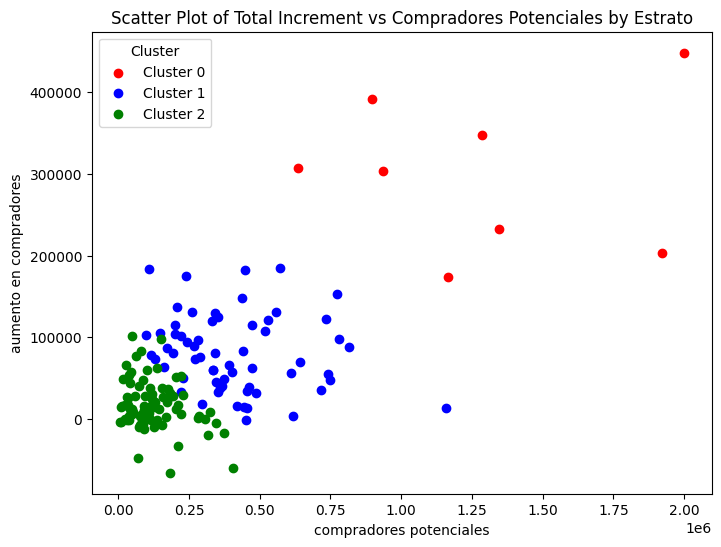

In [23]:
# Updating the colors dictionary for the new category
colors = {0: 'red', 1: 'blue', 2: 'green'}
cambios_vs_oportunidad_clustering['color'] = cambios_vs_oportunidad_clustering['cluster'].map(colors)


# Plotting the scatter plot with the updated categories
plt.figure(figsize=(8, 6))
for cluster,color in colors.items():
    subset = cambios_vs_oportunidad_clustering[cambios_vs_oportunidad_clustering['cluster'] == cluster]
    plt.scatter(subset['FAC_PER_P7_19_2'], subset['total_increment'], label=f'Cluster {cluster}', color=color)

plt.xlabel('compradores potenciales')
plt.ylabel('aumento en compradores')
plt.title('Scatter Plot of Total Increment vs Compradores Potenciales by Estrato')
plt.legend(title='Cluster')
plt.show()

In [30]:
cambios_vs_oportunidad_clustering.to_csv('data/out/cambios_vs_oportunidad_clustering.csv', index=False)

In [24]:
# Updating the function to calculate the top 'num_modes' even if there are fewer unique values
def calculate_modes(df, column, cluster_col, num_modes=3):
    modes_per_cluster = {}
    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster][column]
        # Extend the list to have exactly 'num_modes' items, filling with NaN if necessary
        mode_values = cluster_data.mode().tolist()[:num_modes]
        mode_values.extend([None] * (num_modes - len(mode_values)))  # Fill if fewer modes exist
        modes_per_cluster[cluster] = mode_values
    return modes_per_cluster

# Updating the function to calculate sums instead of means for numerical variables per cluster
def calculate_sums(df, columns, cluster_col):
    sums_per_cluster = {}
    for column in columns:
        sums_per_cluster[column] = df.groupby(cluster_col)[column].sum().to_dict()
    return sums_per_cluster

# Calculating modes for each categorical variable per cluster
modes = {col: calculate_modes(cambios_vs_oportunidad_clustering, col, 'cluster', num_modes=3) for col in categorical_cols}

# Calculating sums for each numerical variable per cluster
sums = calculate_sums(cambios_vs_oportunidad_clustering, numerical_cols, 'cluster')

# Displaying the results
modes, sums


({'GRUPO_EDAD': {1: ['a', None, None],
   0: ['a', 'b', 'd'],
   2: ['g', None, None]},
  'ZONA': {1: ['centro_sur_y_oriente', None, None],
   0: ['centro_sur_y_oriente', 'occidente_y_bajio', None],
   2: ['sur', None, None]},
  'ESTRATO': {1: [2, None, None], 0: [2, None, None], 2: [4, None, None]}},
 {'FAC_PER_P7_19_2': {0: 10184999.0, 1: 25160070.0, 2: 10234906.0},
  'total_increment': {0: 2407495.0, 1: 4987706.0, 2: 1355094.0}})

In [26]:
cambios_vs_oportunidad_clustering.groupby(['cluster'])

In [29]:
cambios_vs_oportunidad_clustering[cambios_vs_oportunidad_clustering['cluster'] == 0]

,GRUPO_EDAD,ZONA,ESTRATO,FAC_PER_P7_19_2,total_increment,cluster,color
1,a,centro_sur_y_oriente,2,1284562.0,347107.0,0,red
16,a,occidente_y_bajio,2,898187.0,391564.0,0,red
24,b,centro_sur_y_oriente,2,937193.0,303718.0,0,red
39,b,occidente_y_bajio,2,635481.0,306760.0,0,red
70,d,centro_sur_y_oriente,2,1998620.0,448468.0,0,red
85,d,occidente_y_bajio,2,1344586.0,233066.0,0,red
93,e,centro_sur_y_oriente,2,1922213.0,202893.0,0,red
108,e,occidente_y_bajio,2,1164157.0,173919.0,0,red
